<h2>
Stock Market Cash Trigger</br>
by Ian Kaplan</br>
</h2>

<p>
This notebook explores a stock market timing strategy that is described in David
Alan Carter's book <i>Stock Market Cash Trigger</i>.
</p>
<p>
This Python notebook is available in the GitHub repository
<a href="https://github.com/IanLKaplan/cash_trigger">
https://github.com/IanLKaplan/cash_trigger</a>
</p>
<p>
In the <i>Stock Market Cash Trigger</i> the 200-day moving average for the S&P 500
ETF SPY close prices is compared with the current close SPY price. When the
close prices for SPY trends below the 200-day moving average, this is a
signal to move out of equity instruments into bond instruments. An ETF rotation strategy
is used to select a bond asset.
</p>
<p>
In the <i>Stock Market Cash Trigger</i> reports that the strategy can perform better
than a "buy and hold" strategy.  Figure 32, from the book is shown below.
</p>

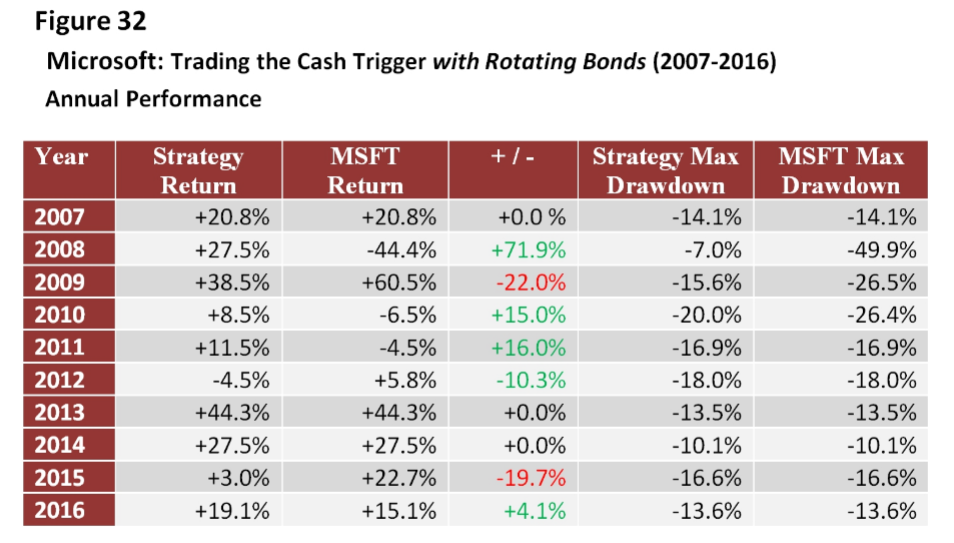

In [7]:
from enum import Enum

from IPython.core.display import Image

Image(filename='images/msft_strategy.png')

<p>
This notebook attempts to reproduce the results from <i>Stock Market Cash Trigger</i>.
</p>
<p>
Technical analysis examines movement, usually price movement, in an attempt to
discover profitable trades.  Technical analysis is sometimes compared to
voodoo magic because many of the trading signals do not have strong quantitative
evicence. Often trading based on technical analysis requires a human because the
rules are not clearly defined enough to implement in computer software.
</p>
<p>
In the <i>Stock Market Cash Trigger</i> the author, David Alan Carter,
discusses why be believes the 200-day moving average is a good trading signal
and compares it to similar signals. Rather than reproduce this discussion
here I recommend that you read the book.
</p>
<p>
The definition of "trending below" the SPY 200-day moving average is when, on the last
day of a month, the close price of SPY is below the 200-day average.
</p>
<p>
The description in the <i>Stock Market Cash Trigger</i> is designed to be used
by human traders. A human trader looking at stock market plots can often see
when the 200-day moving average for SPY is trending below the current the
SPY close price. A computer algorithm generally requires a more exact definition
(an exception might be machine learning algorithms, which are not covered in this
notebook).
</p>
<p>
If the cash trigger points to moving out of equity instruments, a
bond ETF is selected. In the <i>Stock Market Cash Trigger</i> this one
of three bond ETFS: JNK, TLT or MUB.  The
bond ETF that is chosen for the next month is the bond ETF with the
highest three month past return (this is the ETF rotation technique that is
explored at length in the notebook
<a href="https://github.com/IanLKaplan/twelve_percent/blob/master/twelve_percent.ipynb"><i>The 12% Solution</i></a>)
</p>
<p>
The ETF instruments used in this notebook are the same instruments
used in the book <i>Stock Market Cash Trigger</i>
</p>
<h3>
S&P 500 ETF
</h3>
<ul>
<li>
<p>
SPY: SPDR S&P 500 ETF Trust
</p>
<p>
SPY tracks a market-cap-weighted index of US large- and midcap stocks selected by
the S&P Committee (e.g., S&P 500).
</p>
<p>
Inception date: Jan 22, 1993
</p>
</li>
</ul>

<h3>
Bond ETFs
</h3>
<ul>
<li>
<p>
TLT: iShares 20+ Year Treasury Bond ETF
</p>
<p>
TLT tracks a market-weighted index of debt issued by the US Treasury
with remaining maturities of 20 years or more.
</p>
<p>
Inception date: 7/22/2002
</p>
</li>
<li>
<p>
JNK: SPDR Bloomberg High Yield Bond ETF
</p>
<p>
JNK tracks a market-weighted index of highly liquid, high-yield, US
dollar-denominated corporate bonds.
</p>
<p>
Inception date: 11/28/2007
</p>
</li>
<li>
<p>
MUB: iShares National Muni Bond ETF
</p>
<p>
MUB tracks a market-weighted index of investment-grade debt issued by state
and local governments and agencies. Interest is exempt from US income tax
and from AMT.
</p>
<p>
Inception date: 09/09/2007
</p>
</li>
</ul>
<h3>
Time Period
</h3>
<p>
A start date of March 3, 2008 is used to allow a sufficient lookback period
for the JNK ETF.
</p>
<p>
Many examples in the book <i>Stock Market Cash Trigger</i> run from
2007 through 2016. As noted above, the ETF rotation for bonds needs to start in
2008 so that there is sufficient history.
</p>
<h3>
Close Prices vs Adjusted Close Prices
</h3>
<p>
The SPY time series uses SPY close prices, rather than adjusted close prices
that factor in dividend payments. Although SPY does pay a small dividend
(about 1.3%), this can be ignored since the dividend is small.
</p>

<AxesSubplot:title={'center':'SPY and 200-day average: 03/03/2008 - 04/19/2022'}, xlabel='Date'>

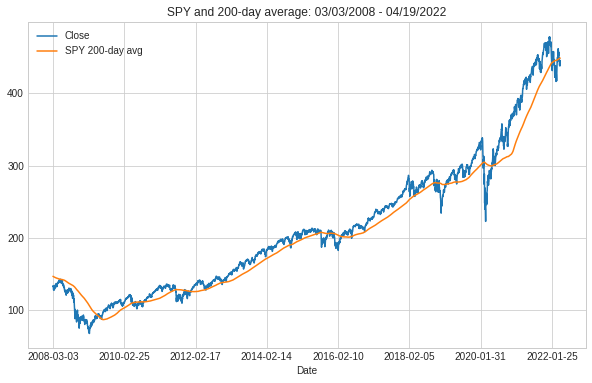

In [8]:
from datetime import datetime, timedelta
from tabulate import tabulate
from typing import List, Tuple
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
from pandas.core.indexes.datetimes import DatetimeIndex
import numpy as np
from pathlib import Path
import tempfile

plt.style.use('seaborn-whitegrid')
pd.options.mode.chained_assignment = 'raise'


def get_market_data(file_name: str,
                    data_col: str,
                    symbols: List,
                    data_source: str,
                    start_date: datetime,
                    end_date: datetime) -> pd.DataFrame:
    """
      file_name: the file name in the temp directory that will be used to store the data
      data_col: the type of data - 'Adj Close', 'Close', 'High', 'Low', 'Open', Volume'
      symbols: a list of symbols to fetch data for
      data_source: yahoo, etc...
      start_date: the start date for the time series
      end_date: the end data for the time series
      Returns: a Pandas DataFrame containing the data.

      If a file of market data does not already exist in the temporary directory, fetch it from the
      data_source.
    """
    temp_root: str = tempfile.gettempdir() + '/'
    file_path: str = temp_root + file_name
    temp_file_path = Path(file_path)
    file_size = 0
    if temp_file_path.exists():
        file_size = temp_file_path.stat().st_size

    if file_size > 0:
        close_data = pd.read_csv(file_path, index_col='Date')
    else:
        panel_data: pd.DataFrame = data.DataReader(symbols, data_source, start_date, end_date)
        close_data: pd.DataFrame = panel_data[data_col]
        close_data.to_csv(file_path)
    assert len(close_data) > 0, f'Error reading data for {symbols}'
    return close_data


trading_days = 252
trading_quarter = trading_days // 4

window_size = 200

data_source = 'yahoo'

start_date_str = '2008-03-03'
start_date: datetime = datetime.fromisoformat(start_date_str)
# The "current date"
end_date: datetime = datetime.today() - timedelta(days=1)


def convert_date(some_date):
    if type(some_date) == str:
        some_date = datetime.fromisoformat(some_date)
    elif type(some_date) == np.datetime64:
        ts = (some_date - np.datetime64('1970-01-01T00:00')) / np.timedelta64(1, 's')
        some_date = datetime.utcfromtimestamp(ts)
    return some_date


def findDateIndex(date_index: DatetimeIndex, search_date: datetime) -> int:
    '''
    In a DatetimeIndex, find the index of the date that is nearest to search_date.
    This date will either be equal to search_date or the next date that is less than
    search_date
    '''
    index: int = -1
    i = 0
    search_date = convert_date(search_date)
    date_t = datetime.today()
    for i in range(0, len(date_index)):
        date_t = convert_date(date_index[i])
        if date_t >= search_date:
            break
    if date_t > search_date:
        index = i - 1
    else:
        index = i
    return index


class RiskState(Enum):
    RISK_OFF = 0
    RISK_ON = 1


class SpyData:
    spy_close_file = 'spy_close'
    spy_etf = "SPY"
    spy_close: pd.DataFrame
    date_index: DatetimeIndex

    def __init__(self, start_date: datetime, end_date: datetime) -> object:
        """
        start_date: the start of the period for the SPY data.  One year
        before this date will be fetched to allow for a moving average
        from start_date
        end_date: the end of the period for the SPY data.
        """
        spy_start: datetime = start_date - timedelta(days=365)
        self.spy_close = get_market_data(file_name=self.spy_close_file,
                                         data_col='Close',
                                         symbols=self.spy_etf,
                                         data_source=data_source,
                                         start_date=spy_start,
                                         end_date=end_date)
        self.date_index = self.spy_close.index

    def close_data(self, start_date: datetime, end_date: datetime) -> pd.DataFrame:
        """
        Return a section of SPY close prices from start_date to end_date
        """
        start_ix = findDateIndex(date_index=self.date_index, search_date=start_date)
        end_ix = findDateIndex(date_index=self.date_index, search_date=end_date)
        spy_close_df = pd.DataFrame()
        assert start_ix >= 0 and end_ix >= 0
        spy_close_df = self.spy_close[:][start_ix:end_ix+1].copy()
        return spy_close_df

    def avg(self, day: datetime, window: int = window_size) -> float:
        """
        :param day: the end date for the window
        :param window: the size of the window extending back from day
        :return: the average for the SPY close prices in the window
        """
        _average: float = -1.0
        end_ix = findDateIndex(date_index=self.date_index, search_date=day)
        start_ix = end_ix - (window -1)
        assert start_ix >= 0 and end_ix >= 0
        _average = self.spy_close.values[start_ix:end_ix+1].mean()
        return _average

    def moving_sum(self, values: np.array, start_ix: int, end_ix: int, win_size: int) -> np.array:
            sum_l: list = []
            win_start_ix = start_ix - (win_size - 1)
            win_end_ix = start_ix
            sum = values[win_start_ix:win_end_ix + 1].sum()
            win_end_ix = win_end_ix + 1
            sum_l.append(float(sum))
            while win_end_ix <= end_ix:
                win_start_ix = win_end_ix - win_size
                start_val = float(values[win_start_ix])
                end_val = float(values[win_end_ix])
                sum = (sum - start_val) + end_val
                sum_l.append(sum)
                win_end_ix = win_end_ix + 1
            sum_a = np.array(sum_l)
            return sum_a

    def moving_avg(self, start_date: datetime, end_date: datetime, window: int = window_size) -> pd.DataFrame:
        """
        Compute a moving average series
        :param start_date: the start date for the moving average series
        :param end_date: the end date for the moving average series
        :param window: the window size that extends, initially, back from start_date
        :return: a moving average series as a DataFrame. The date index will be the same
                 as the SPY time DataFrame between start_date and end_date
        """
        start_ix = findDateIndex(date_index=self.date_index, search_date=start_date)
        end_ix = findDateIndex(date_index=self.date_index, search_date=end_date)
        assert start_ix >= 0 and end_ix >= 0
        spy_values = self.spy_close.values
        sum_a: np.array = self.moving_sum(values=spy_values,
                                start_ix=start_ix,
                                end_ix=end_ix,
                                win_size=window_size)
        avg_a = sum_a / window_size
        avg_df = pd.DataFrame(avg_a)
        avg_index = self.date_index[start_ix:end_ix+1]
        avg_df.index = avg_index
        avg_df.columns = [f'{self.spy_etf} {window_size}-day avg']
        return avg_df

    def risk_state(self, day: datetime) -> RiskState:
        spy_avg = self.avg(day)
        day_ix = findDateIndex(date_index=self.date_index, search_date=day)
        spy_val = float(self.spy_close.values[day_ix:day_ix+1])
        # only use full dollar price changes
        spy_avg = round(spy_avg, 0)
        spy_val = round(spy_val, 0)
        state: RiskState = RiskState.RISK_ON if spy_val < spy_avg else RiskState.RISK_OFF
        return state


spy_data = SpyData(start_date, end_date)
spy_close = spy_data.close_data(start_date, end_date)
spy_moving_avg = spy_data.moving_avg(start_date, end_date)
plot_df = pd.concat([spy_close, spy_moving_avg], axis=1)

<h3>
200-day SPY moving average
</h3>
<p>
The plot below shows the 200-day SPY moving average, plotted with the SPY close
prices.
</p>
<p>
The strategy moves out of equities into bonds when the SPY close price is below
the 200-day moving average.  Looking at this plot you can see that it looks like the
market downturns are all below the 200-day moving average.
</p>

In [ ]:
plot_df.plot(grid=True, title=f'SPY and 200-day average: {start_date.strftime("%m/%d/%Y")} - {end_date.strftime("%m/%d/%Y")}', figsize=(10,6))

<h2>
Cash Trigger Strategy
</h2>
<p>
The <a href="https://www.trendlineprofits.com/">trendlineprofits.com</a> website
is available to purchasers of the <i>Stock Market Cash Trigger</i> book.  The
website has a concise description of the cash trigger strategy that is quoted
below.
the
</p>
<blockquote>
<p>
Once a month, preferably on the last trading day of the month, the strategy
first determines whether the broader U.S. stock market is in a risk-on or risk-off
regime using the 200-day simple moving average of SPY. This is our Regime-O-Meter.
If the price line for SPY is trending above its 200-day simple moving average,
it's risk-on -- and off to the races. Translation: You buy and hold the risk
asset(s) of your choice.
</p>
<p>
On the other hand, if the price line of SPY is trending below the 200-day MA,
the broader market is in a risk-off environment. In that case, we buy and hold
one of four flight-to-safety bond funds as determined by a relative strength
test using a 3-month lookback.
</p>
<p>
Rinse and repeat the next month.
</p>
<p>
So, at any given time our Cash Trigger portfolio holds either the risk assets
of your choice, or a single flight-to-safety bond fund.
</p>
</blockquote>

<h3>
First day vs. last day of the month
</h3>
<p>
Software from <a href="https://github.com/IanLKaplan/twelve_percent/blob/master/twelve_percent.ipynb"><i>The 12% Solution</i></a>
is resued in this notebook. <i>The 12% Solution</i> strategy trades at the start of
every month, instead of the end of the money.
</p>
<p>
In the Q&A section of <i>Stock Market Cash Trigger</i> the author writes that there
is, at most, a small advantage in trading at the end of the month.
</p>
<p>
In keeping with <i>The 12% Solution</i> strategy trading is at the start of the month
in this notebook.
</p>

In [ ]:
def chooseAssetName(start: int, end: int, asset_set: pd.DataFrame) -> str:
    '''
    Choose an ETF asset in a particular range of close price values.
    The function returns the name of the asset with the highest returning
    asset in the period.
    '''
    asset_columns = asset_set.columns
    asset_name = asset_columns[0]
    if len(asset_columns) > 1:
        ret_list = []
        start_date = asset_set.index[start]
        end_date = asset_set.index[end]
        for asset in asset_set.columns:
            ts = asset_set[asset][start:end+1]
            start_val = ts[0]
            end_val = ts[-1]
            r = (end_val/start_val) - 1
            ret_list.append(r)
        ret_df = pd.DataFrame(ret_list).transpose()
        ret_df.columns = asset_set.columns
        ret_df = round(ret_df, 3)
        column = ret_df.idxmax(axis=1)[0]
        asset_name = column
    return asset_name


def find_month_periods(start_date: datetime, end_date:datetime, data: pd.DataFrame) -> pd.DataFrame:
    start_date = convert_date(start_date)
    end_date = convert_date(end_date)
    date_index = data.index
    start_ix = findDateIndex(date_index, start_date)
    end_ix = findDateIndex(date_index, end_date)
    start_l = list()
    end_l = list()
    cur_month = start_date.month
    start_l.append(start_ix)
    i = 0
    for i in range(start_ix, end_ix+1):
        date_i = convert_date(date_index[i])
        if date_i.month != cur_month:
            end_l.append(i-1)
            start_l.append(i)
            cur_month = date_i.month
    end_l.append(i)
    # if there is not a full month period, remove the last period
    if end_l[-1] - start_l[-1] < 18:
        end_l.pop()
        start_l.pop()
    start_df = pd.DataFrame(start_l)
    end_df = pd.DataFrame(end_l)
    start_date_df = pd.DataFrame(date_index[start_l])
    end_date_df = pd.DataFrame(date_index[end_l])
    periods_df = pd.concat([start_df, start_date_df, end_df, end_date_df], axis=1)
    periods_df.columns = ['start_ix', 'start_date', 'end_ix', 'end_date']
    return periods_df


def simple_return(time_series: np.array, period: int = 1) -> List :
    return list(((time_series[i]/time_series[i-period]) - 1.0 for i in range(period, len(time_series), period)))


def return_df(time_series_df: pd.DataFrame) -> pd.DataFrame:
    r_df: pd.DataFrame = pd.DataFrame()
    time_series_a: np.array = time_series_df.values
    return_l = simple_return(time_series_a, 1)
    r_df = pd.DataFrame(return_l)
    date_index = time_series_df.index
    r_df.index = date_index[1:len(date_index)]
    r_df.columns = time_series_df.columns
    return r_df


def apply_return(start_val: float, return_df: pd.DataFrame) -> np.array:
    port_a: np.array = np.zeros( return_df.shape[0] + 1)
    port_a[0] = start_val
    return_a = return_df.values
    for i in range(1, len(port_a)):
        port_a[i] = port_a[i-1] + port_a[i-1] * return_a[i-1]
    return port_a


def portfolio_return(holdings: float,
                     risk_asset: pd.DataFrame,
                     bond_asset: pd.DataFrame,
                     spy_data: SpyData,
                     start_date: datetime,
                     end_date: datetime) -> pd.DataFrame:
    portfolio_a = np.zeros(0)
    portfolio_val = holdings
    month_periods = find_month_periods(start_date, end_date, risk_asset)
    for period in month_periods:
        start_ix = period['start_ix']
        end_ix = period['end_ix']
        start_date: datetime = convert_date(period['start_date'])
        r_df = pd.DataFrame()
        if spy_data.risk_state(start_date) == RiskState.RISK_ON:
            risk_name: str = chooseAssetName(start_ix, end_ix, risk_asset)
            risk_close_prices = risk_asset[risk_name][start_ix:end_ix+1]
            r_df = return_df(risk_close_prices)
        else: # RISK_OFF - bonds
            bond_name: str = chooseAssetName(start_ix, end_ix, bond_asset)
            bond_close_prices = bond_asset[bond_name][start_ix:end_ix+1]
            r_df = return_df(bond_close_prices)
        port_month_a = apply_return(portfolio_val, r_df)
        portfolio_val = port_month_a[-1]
        portfolio_a = np.append(portfolio_a, port_month_a)
    portfolio_df = pd.DataFrame(portfolio_a)
    portfolio_df.columns = ['portfolio']
    num_rows = month_periods.shape[0]
    first_row = month_periods[:][0:1]
    last_row = month_periods[:][num_rows - 1:num_rows]
    start_ix = first_row['start_ix'].values[0]
    end_ix = last_row['end_ix'].values[0]
    date_index = risk_asset.index
    portfolio_index = date_index[start_ix:end_ix + 1]
    portfolio_df.index = portfolio_index
    return portfolio_df




<h2>
Disclaimer
</h2>
<p>
This notebook is not financial advice, investment advice, or tax advice.
The information in this notebook is for informational and recreational purposes only.
Investment products discussed (ETFs, mutual funds, etc.) are for illustrative purposes
only. This is not a recommendation to buy, sell, or otherwise transact in any of the
products mentioned. Do your own due diligence. Past performance does not guarantee
future returns.
</p>